# The Easiest Way to Deploy Your ML/DL Models in 2022: Streamlit + BentoML + DagsHub
## Deploy models as lightweight APIs with a user-friendly interface
![](images/pexels.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/photo/blue-red-and-black-abstract-painting-2130475/'>Steve Johnson</a>
    </strong>
</figcaption>


### Introduction

You have a ready machine learning model. Now what? What do you do with it? Do you keep it inside your Jupyter like a prized possession for no one to see? No, you make it as stupidly easy as possible for others to share and play around with your work. In other words, you *deploy* the model.

But how? Should you just share the model as a file? No, that would be the worst.

How about a Docker container? Yeah, that is better - the user will have it all to run your model locally. But... they would still need to do it inside a coding environment. Not very convenient. 

Then, what about an API? Well, good luck explaining what an API is to a non-programmer person. 

Hey, what if you built a web app with a minimal interface? Yes, this seems to be the best option. But how do build the app? Don't you need to learn a web framework for that? That's too much work!

### What problem are we solving?

### What tools will we be using to deploy?

### Step 1: Save the best model to BentoML local store

Let's start by importing the necessary libraries:

```python
import logging

import bentoml  # pip install bentoml --pre
import joblib
import tensorflow as tf
```

Make sure you install `bentoml` with the `--pre` tag since it is still in preview. 

Below, we will create a couple helper functions to create and train a Keras convolution model:

```python
def get_keras_conv2d():
    """A function to build an instance of a Keras conv2d model."""
    
    model = ...
    
    return model


def fit_keras_conv2d():
    """
    A function to train a Keras conv2d model.
    """
    model = get_keras_conv2d()
    
    #-- Fit model with early stopping and 30 epochs on the images --#
    
    return model
```

I've left the body of the first function but all it does is it creates a Conv2D instance with three hidden layers, with dropout and MaxPool layers in-between. We don't have to focus on model architecture too much. 

`fit_keras_conv2d` uses the first function and trains the obtained model with early stopping and 30 epochs.

Next, we create a function to save the model to BentoML local store:

```python
def save(model, bentoml_name, path):
    """
    A function to save a given model to BentoML local store and with joblib.
    """
    bentoml.keras.save(bentoml_name, model, store_as_json_and_weights=True)
    
    joblib.dump(model, path)
```

The `keras.save` function specifically saves Keras models in a format suitable for other BentoML operations. 

So, let's run these functions to get a ready model:

```python
def main():
    
    model = fit_keras_conv2d()
    
    logging.log(logging.INFO, "Saving...")
    
    save(model, 
         "keras_conv2d_smaller", 
         "models/keras_conv2d_smaller.joblib")
    
    logging.log(logging.INFO, "Done!")
    
if __name__ == "__main__":
    main()
```

After the training and saving is done, you can run the below command to get a list of models in the BentoML store:

```bash
$ bentoml models list
```
![](images/models_list.gif)


The saved models are officially called *tags* in the BentoML docs. By default, all models will be saved under your home directory and the `bentoml/models` folder with a random tag name, in case there are multiple models with the same name.

If you go into the given path, you will find files like these:

```
checkpoint
model.yaml
saved_model_json.json
saved_model_weights.data-00000-of-00001
saved_model_weights.index
```

You can always load the model back using the `load_runner` function preceded by the relevant framework name:

```python
model = bentoml.keras.load_runner("keras_conv2d_smaller:latest")

# Load a sample image from memory
img = ...

print(model.run(img))
```

After loading, the model can be used for prediction using its `run` method, which calls the `predict` method of Keras `Model` object under the hood.

### Step 2: Create the service

Now, we only need to write a few lines of code to convert the saved model into a functioning API we can send requests to. 

First, we write a function to create a Service object of BentoML that takes care of all API logic without any effort on our part. 

After loading the model back with the `load_runner` function, we pass it to the `Service` method with an arbitrary name. 

```python
def create_bento_service_keras(bento_name):
    """
    Create a Bento service for a Keras model.
    """
    # Load the model
    keras_model = bentoml.keras.load_runner(bento_name)

    # Create the service
    service = bentoml.Service(bento_name + "_service", runners=[keras_model])

    return keras_model, service

model, service = create_bento_service_keras("conv2d_larger_dropout")

```

After that, we create an API endpoint that handles our POST requests. You create endpoints in BentoML by defining a function decorated with the `api` method of the service object we just created:

```python
import numpy as np
import bentoml
from bentoml.io import Text, NumpyNdarray
from skimage.transform import resize
```

```python
# Create an API function
@service.api(input=Text(), output=NumpyNdarray())
def predict(image_str) -> np.ndarray:
    """
    Predict pet pawpularity from an image using the given Bento.
    """
    # Convert the image back to numpy array
    image = np.fromstring(image_str, np.uint8)
    image = resize(image, (224, 224, 3))
    image = image / 255.0

    result = model.run(image)

    return result
```

Before discussing body, let's talk about the `service.api` decorator. It has two required parameters - `input` and `output`. 

These parameters should be defined based on what type of data we will be sending and getting back from the API endpoint. 

The purpose of the above `predict` endpoint is that it returns a cuteness score when we send a request with an image. So, I've defined the input as `Text()` because we will be sending the NumPy image array as a string. The output should be `NumpyNdarray()` because when we call `model.run(image)`, the return data type will be a Numpy array.

Getting the right data type for the endpoint is important. You can read [this page](https://docs.bentoml.org/en/latest/api/api_io_descriptors.html?highlight=Image#api-io-descriptors) of the BentoML docs on other types of data you can process through endpoints.

As for the body, you should write all preprocessing logic to the image before you call `model.run`. While writing the training logic, I've resized the images to (224, 224, 3) and normalized them by dividing their pixel values by 255. So, I've performed those steps inside the endpoint function as well.

> Important: If you are using other frameworks like Sklearn for tabular data, make sure you run all your preprocessing steps inside the API endpoint as well. We can achieve this by pickling all your processing functions and calling them inside the `predict` function, so there won't be any data leakage or you won't pass incorrectly formatted data.

Now, to start a debug server for our API, you only need to put all above into a single Python file, conventionally named `service.py`, in the root directory and call the below command:

```bash
$ bentoml serve service.py:service --reload
```

![](images/bentoml_serve.gif)

The `--reload` tag makes sure that the local server detects changes to the `service.py` and updates the logic automatically. 

From the GIF, you can see that the server is live at http://127.0.0.1:3000/ with a simple UI:
![](images/local_server.gif)

We can already send requests to the local server and get predictions for the images:

```python

import requests
from skimage.io import imread

endpoint = "http://127.0.0.1:3000/predict"

# Load a sample image
img = imread("data/raw/train/0a0da090aa9f0342444a7df4dc250c66.jpg")

response = requests.post(endpoint, headers={"content-type": "text/plain"},
                    data=str(img))
```

Make sure to set the right headers for your data type and send the image wrapped under the `str` function. Once again, you can find the examples of requests with the right content headers for each data type from [this page](https://docs.bentoml.org/en/latest/concepts/api_io_descriptors.html#) of the docs.

Let's look at the response text:

```python
>>> print(response.text)
[35.49753189086914]
```

And the image we sent was this:

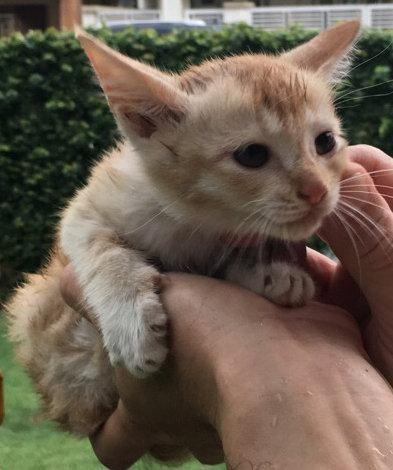
<figcaption style="text-align: center;">
    <strong>
        Image from the <a href='https://www.kaggle.com/competitions/petfinder-pawpularity-score/data'>Pet Pawpularity dataset</a>.
    </strong>
</figcaption>

### Step 3: Build the Bento

Now, we are ready to create our very first Bento. 

The term Bento means an archive that contains everything to run our services or API online, including all the code, model, dependency info, and configurations for setup. Building it starts with creating a `bentofile.yaml` file in the directory that is the same level as the `service.py` file (preferably, both should be in the project root):

```YAML
service: "service.py:service"
include:
 - "service.py"
python:
  packages:
   - scikit_learn==1.0.2
   - numpy==1.22.3
   - tensorflow==2.8.0
   - scikit_image==0.18.3
```

The first line of the YAML file should contain the service file's name followed by ":service" suffix. Next, you add all the files needed for the `service.py` file work without errors (data, helper scripts, etc.). Here, I only included the service file itself as we didn't use any additional scripts inside it.

Then, under Python and packages, you specify the dependencies and their versions. If you are not sure about the versions, there is a helpful little package I always use called `pipreqs`:

```bash
$ pip install pipreqs

$ pipreqs .
```

Calling `pipreqs [path]` creates a `requirements.txt` file with all the used packages inside your Python files and their versions in the given path like below: 

```
bentoml==1.0.0a7
catboost==0.26.1
dagshub==0.1.8
joblib==0.17.0
keras==2.8.0
lightgbm==2.3.1
matplotlib==3.3.1
mlflow==1.24.0
numpy==1.22.3
pandas==1.3.2
scikit_image==0.18.3
scikit_learn==1.0.2
seaborn==0.11.0
skimage==0.0
tensorflow==2.8.0
tqdm==4.50.0
xgboost==1.4.2

```

After listing the dependencies, you only need to call `bentoml build`:

```bash
$ bentoml build
```

![](images/bento_build.png)

To see a list of all your bentos, call `bentoml list`

```bash
$ bentoml list
```
![](images/bento_list.png)

### Step 4: Deploy to Heroku

```bash
    ├───apis
    │       openapi.yaml
    ├───env
    │   ├───conda
    │   ├───docker
    │   │       Dockerfile
    │   │       entrypoint.sh
    │   │       init.sh
    │   └───python
    │           requirements.lock.txt
    │           requirements.txt
    ├───models
    │   └───keras_conv2d
    │       │   latest
    │       │
    │       └───b52h7x5xpk2bejcl
    │               checkpoint
    │               model.yaml
    │               saved_model_json.json
    │               saved_model_weights.data-00000-of-00001
    │               saved_model_weights.index
    └───src
    │       service.py
    │   bento.yaml
    │   README.md
```

```bash
$ heroku login
```

```bash
$ heroku container:login
```

```bash
$ heroku create pet-pawpularity
```

```bash
$ cd ~/bentoml/bentos/keras_conv2d_smaller_service/uaaub3v3cku3ejcl
$ cd env/docker

$ heroku container:push web --app pet-pawpularity --context-path=../..
```

```bash
$ heroku container:release web --app pet-pawpularity
```

### Step 5: Build the UI with Streamlit

### Conclusion